In [1]:
import visualID_Eng as vID
vID.init()

**Start at:** Thursday 16 June 2022, 12:48:44  
**Hostname:** insa-11357 (Linux)

<p style="text-align: center"><img width="800px" src="./svg/logoPytChem.svg" style="margin-left:auto; margin-right:auto"/></p>

# Prediction of CO<sub>2</sub> solubility with an ANN
**Reference**: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [*Chem. Eng. Sci.* **223**: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 

In [2]:
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
import os,sys
from IPython.display import display
    
import numpy as np
import pandas as pd
from IPython.display import display

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   OFF = '\033[0m'

<a id="data-read"></a>
## **1.** Basic data analysis and visualization
The [pandas library](https://pandas.pydata.org/docs/index.html) provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language. It is recommended to first have a look at the [10mn short introduction to pandas](https://pandas.pydata.org/docs/user_guide/10min.html).
### **1.a.** Read the database

In [3]:
dataCO2f='CO2-data'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### **1.b.** Any correlation between data?

       x_CO2
[CH3]       
0        855
1       8350
2        108
3         92
4        639
7         72

Duration :  00:00:02 951ms


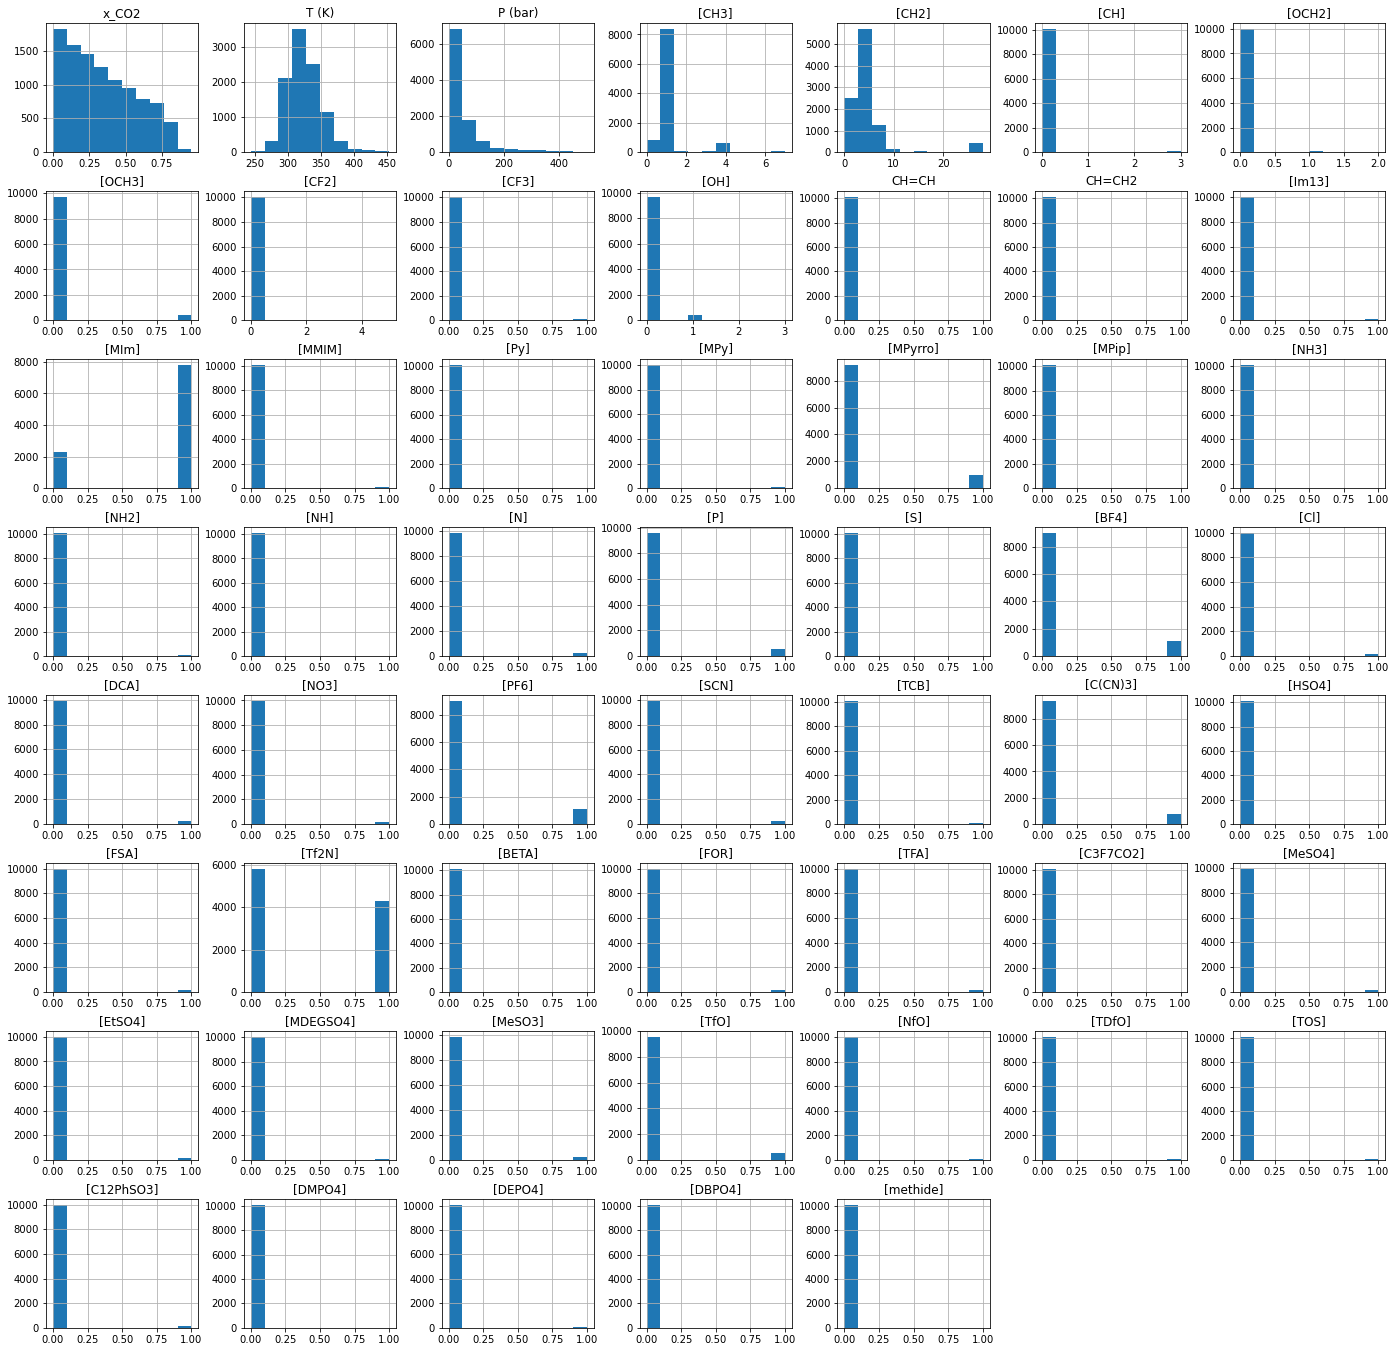

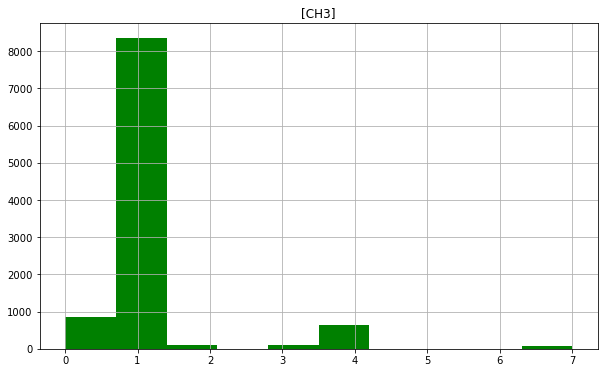

In [4]:
vID.chrono_start()
dataCO2.hist(figsize=(24,24))
print(dataCO2[["x_CO2", "[CH3]"]].groupby("[CH3]").count())
dataCO2.hist("[CH3]",figsize=(10,6),facecolor='g')
vID.chrono_show()

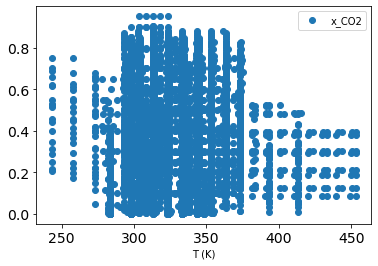

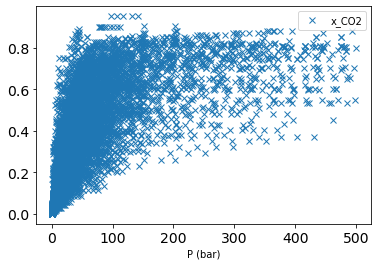

In [5]:
fig1=dataCO2.plot(x="T (K)", y=["x_CO2"],linestyle='', marker='o',fontsize=14)
fig2=dataCO2.plot(x="P (bar)", y=["x_CO2"],linestyle='', marker='x',fontsize=14)

## 2. Prediction of the solubility of CO<sub>2</sub> by deep learning: **minimal python code**

### 2.1. ML scheme

<p style="text-align: center"><img width="750px" src="./CO2-images/ANN-CO2Song_etal.png" style="margin-left:auto; margin-right:auto" id="img_Song"></img></p>

**Methodological details:**
- The MATLAB tansig and purelin transfer functions are employed in the hidden and output layers, respectively
- The experimental data are divided into a training set (8093 points, 80% of the data) to build the model and a test set of the remaining 2023 data points to evaluate the predictive capability of the obtained model
- Instead of performing random selection, we employ a hybrid artificial-random strategy to decompose the dataset. Specifically, the data points consisting of the least frequently used groups are equally divided into five folders

In [6]:
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)
pw=4
ph=4

#### Relu function

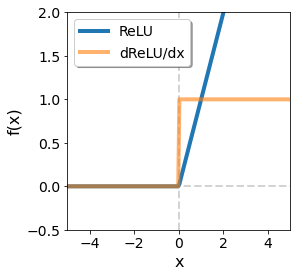

In [7]:
def relu(z):
    return np.maximum(0, z)

figR, axR = plt.subplots(1, 1)
figR.set_size_inches(pw,ph)
axR.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axR.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axR.plot(z, relu(z),linewidth=4,label="ReLU")
axR.plot(z, derivative(relu, z), linewidth=4, alpha=0.6, label="dReLU/dx")
axR.legend(loc='upper left', shadow=True, fontsize='14')
axR.set_xlabel('x',fontdict={'fontsize':16})
axR.set_ylabel('f(x)',fontdict={'fontsize':16})
axR.set_xlim(-5, 5)
axR.set_ylim(-0.5, 2)
axR.tick_params(labelsize = 14)
plt.show()


#### tanh function

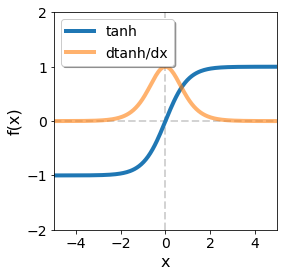

In [8]:
def tanh(z):
    return np.tanh(z)

figT, axT = plt.subplots(1, 1)
figT.set_size_inches(pw,ph)
axT.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axT.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axT.plot(z, tanh(z),linewidth=4,label="tanh")
axT.plot(z, derivative(tanh, z), linewidth=4, alpha=0.6, label="dtanh/dx")
axT.legend(loc='upper left', shadow=True, fontsize='14')
axT.set_xlabel('x',fontdict={'fontsize':16})
axT.set_ylabel('f(x)',fontdict={'fontsize':16})
axT.set_xlim(-5, 5)
axT.set_ylim(-2, 2)
axT.tick_params(labelsize = 14)
plt.show()


### 2.2. Script 1

Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  
MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

In [ ]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0, random_state=1)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

display(x_train,y_train)
display(x_test,y_test)

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 5,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
diffyt = ytrain_hat.ravel() - y_train.ravel()
diffyp = ytest_hat.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1]
     )

#######################################################################################
# save model for later use

#!mkdir -p saved_models
#ANNmodel.save('saved_models/ANNmodel-basic')

### 2.2. Script 2

In [9]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0, random_state=1)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

display(x_train.describe().style.format("{0:.2f}").set_caption("Training set before normalization :"))

# using scikit-learn
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
xtrain_scaled = scaler.transform(x_train.values) #returns a numpy array
xtest_scaled = scaler.transform(x_test.values) #returns a numpy array
x_train = pd.DataFrame(xtrain_scaled)
x_test = pd.DataFrame(xtest_scaled)

# display difference (if any)
display(x_train.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
display(x_test.describe().style.format("{0:.2f}").set_caption("Test set after normalization (with scikit-learn):"))
del xtrain_scaled, xtest_scaled


#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 25,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
diffyt = ytrain_hat.ravel() - y_train.ravel()
diffyp = ytest_hat.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1]
     )

#######################################################################################
# save model for later use

#!mkdir -p saved_models
#ANNmodel.save('saved_models/ANNmodel-basic')

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,325.37,54.56,1.18,4.76,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.01,0.01,0.10,0.00,0.00,0.01,0.00,0.02,0.06,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.08,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,25.44,77.35,0.97,5.55,0.26,0.16,0.20,0.40,0.10,0.28,0.07,0.06,0.10,0.42,0.08,0.07,0.11,0.30,0.06,0.07,0.09,0.06,0.15,0.23,0.06,0.31,0.12,0.14,0.13,0.31,0.14,0.08,0.27,0.04,0.12,0.49,0.04,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.22,0.09,0.08,0.06,0.10,0.04,0.08,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,9.98,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,27.20,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,342.85,64.50,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.23,-0.71,-1.21,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
25%,-0.68,-0.58,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
50%,-0.09,-0.35,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
75%,0.69,0.13,-0.18,0.04,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,1.16,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
max,5.02,5.76,6.01,4.19,11.57,12.38,4.79,12.37,9.88,10.48,14.96,15.87,9.88,0.55,12.68,13.68,9.22,3.06,16.13,14.19,11.38,16.97,6.43,4.14,17.96,2.85,7.98,6.93,7.74,2.85,7.11,13.23,3.49,28.43,8.56,1.16,28.43,8.64,8.99,18.34,7.46,9.33,9.65,6.65,4.24,10.63,12.68,15.63,9.54,27.11,12.95,22.47,21.18


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,-0.02,-0.02,0.00,-0.03,-0.02,0.01,0.01,-0.01,-0.01,-0.00,-0.02,-0.01,0.03,0.03,0.02,-0.04,-0.02,-0.03,-0.02,-0.01,0.00,0.00,0.04,-0.03,0.07,0.02,-0.00,0.05,-0.02,0.02,0.04,0.03,-0.03,0.01,-0.01,-0.03,-0.02,-0.00,0.01,-0.02,-0.00,-0.00,-0.01,0.02,0.05,-0.06,-0.02,-0.04,0.01,-0.02,-0.02,-0.02,-0.02
std,0.96,0.95,0.96,0.94,0.90,1.06,1.02,0.90,0.96,1.00,0.82,0.94,1.12,0.98,1.10,0.68,0.92,0.95,0.80,0.90,1.02,1.00,1.12,0.93,1.49,1.02,1.00,1.15,0.90,1.02,1.14,1.18,0.96,1.10,0.98,1.00,0.63,0.99,1.04,0.82,0.99,0.98,0.97,1.07,1.09,0.63,0.85,0.60,1.04,0.60,0.87,0.71,0.82
min,-3.23,-0.71,-1.21,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
25%,-0.70,-0.58,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
50%,-0.09,-0.38,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
75%,0.51,0.14,-0.18,0.04,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,1.16,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
max,5.02,5.73,6.01,4.19,11.57,12.38,4.79,12.37,9.88,10.48,14.96,15.87,9.88,0.55,12.68,13.68,9.22,3.06,16.13,14.19,11.38,16.97,6.43,4.14,17.96,2.85,7.98,6.93,7.74,2.85,7.11,13.23,3.49,28.43,8.56,1.16,28.43,8.64,8.99,18.34,7.46,9.33,9.65,6.65,4.24,10.63,12.68,15.63,9.54,27.11,12.95,22.47,21.18


2022-06-16 12:49:40.967429: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-16 12:49:40.967759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 12:49:40.968695: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-06-16 12:49:41.078019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-16 12:49:41.078980: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hLayer (Dense)               (None, 7)                 378       
_________________________________________________________________
oLayer (Dense)               (None, 1)                 8         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
324/324 [==============================] - 2s 4ms/step - loss: 0.4057 - mae: 0.4083 - mse: 0.4057 - val_loss: 0.0538 - val_mae: 0.1556 - val_mse: 0.0538
Epoch 2/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0460 - mae: 0.1452 - mse: 0.0460 - val_loss: 0.0214 - val_mae: 0.1113 - val_mse: 0.0214
Epoch 3/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0193 - mae: 0.1068 - mse: 0.0193 - val_loss: 0.0159 - val_mae: 0.0971 - val_mse: 0.0159
Epoch 4/200
324/324 [====

## **3.** <a id="model-evaluation"></a>Model evaluation

### **3.1.** Loss, MAE and MSE as a function of epochs = during the ANN optimization with the back-propagation algorithm 

  x_train / loss      : 0.0014
x_train/ mae       : 0.0277
x_train / mse       : 0.0014 

  x_test / loss      : 0.0014
x_test / mae       : 0.0281
x_test / mse       : 0.0014 


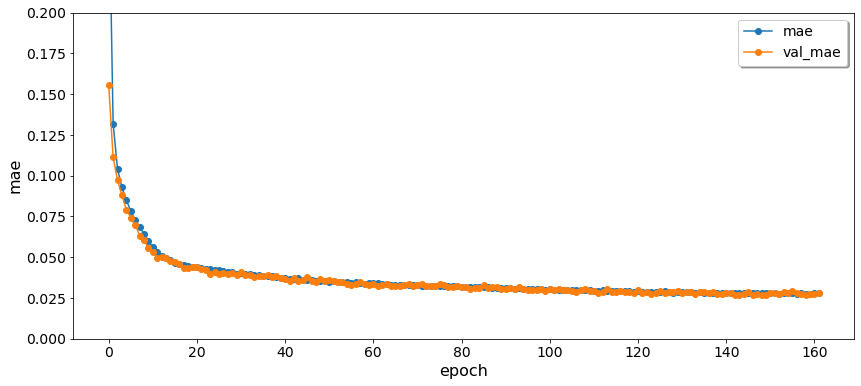

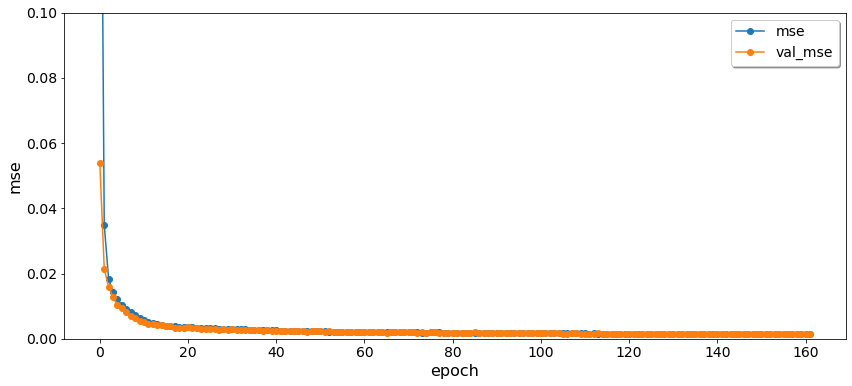

In [23]:
ANNscoreTrain= ANNmodel.evaluate(x_train, y_train, verbose=0)
print(color.GREEN,color.GREEN,'x_train / loss      : {:5.4f}'.format(ANNscoreTrain[0]))
print('x_train/ mae       : {:5.4f}'.format(ANNscoreTrain[1]))
print('x_train / mse       : {:5.4f}'.format(ANNscoreTrain[2]),color.OFF)
print()
ANNscoreEval = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(color.BLUE,color.BLUE,'x_test / loss      : {:5.4f}'.format(ANNscoreEval[0]))
print('x_test / mae       : {:5.4f}'.format(ANNscoreEval[1]))
print('x_test / mse       : {:5.4f}'.format(ANNscoreEval[2]),color.OFF)

df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
figMAE=df.plot(y=["mae","val_mae"],linestyle='-', marker='o',fontsize=14)
figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
figMAE.set_ylabel('mae',fontdict={'fontsize':16})
figMAE.set_ylim([0.0,0.2])
figMAE.legend(loc='upper right', shadow=True, fontsize='14')
figMSE=df.plot(y=["mse","val_mse"],linestyle='-', marker='o',fontsize=14)
figMSE.set_xlabel('epoch',fontdict={'fontsize':16})
figMSE.set_ylabel('mse',fontdict={'fontsize':16})
figMSE.set_ylim([0.0,0.1])
figMSE.legend(loc='upper right', shadow=True, fontsize='14')

### **3.2.** Comparison between experimental and predicted CO<sub>2</sub> solubility

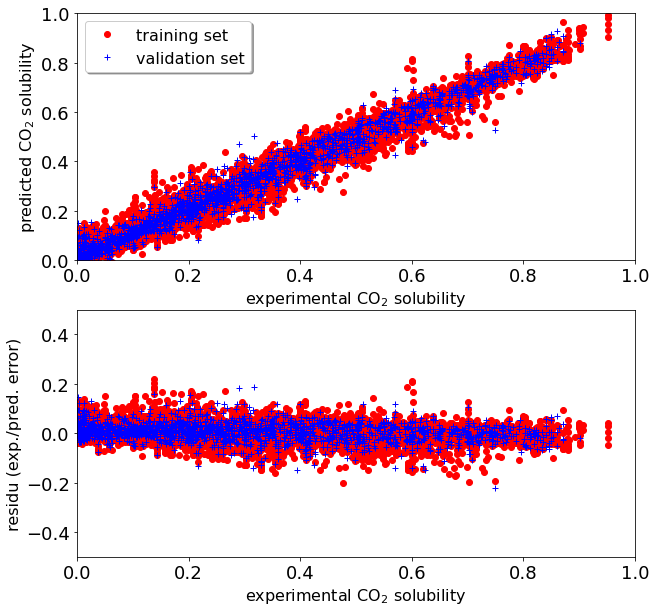

In [32]:
import matplotlib.gridspec as gridspec
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
plt.subplot(gs[0])
plt.plot(y_train,ytrain_hat,'ro',label='training set')
plt.plot(y_test,ytest_hat,'b+',label='validation set')
plt.xlabel('experimental CO$_2$ solubility',fontsize=16)
plt.ylabel('predicted CO$_2$ solubility',fontsize=16)
plt.xlim(0,1);plt.ylim(0,1) 
plt.legend(loc='upper left', shadow=True, fontsize='16')
plt.subplot(gs[1])
plt.plot(y_train,diffyt,'ro',label='training set')
plt.plot(y_test,diffyp,'b+',label='validation set')
plt.xlabel('experimental CO$_2$ solubility',fontsize=16)
plt.ylabel('residu (exp./pred. error)',fontsize=16)
plt.xlim(0.0,1.0); plt.ylim(-0.5,0.5)

plt.savefig('./CO2-images/predictionCO2.png',dpi=300,bbox_inches='tight')

### **3.3.** Residus (distribution of the error)

 Train. mean: 0.004    std: 0.038    MAE: 0.028     R2: 0.987
  Test. mean: 0.006    std: 0.038    MAE: 0.028     R2: 0.987


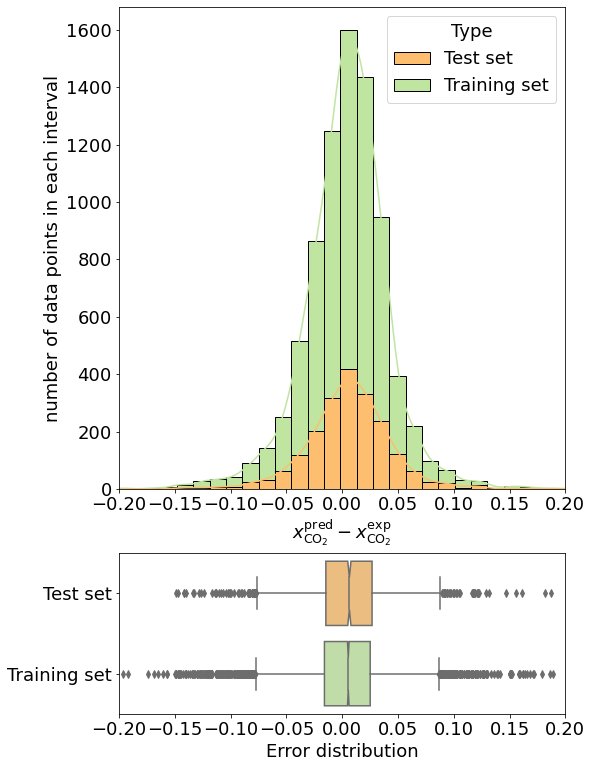

In [26]:
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt)),
      "   std: {:.3f}".format(np.std(diffyt)),
      "   MAE: {:.3f}".format(np.average(abs(diffyt))),
      "    R2: {:.3f}".format(np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1])
     )
print(color.GREEN,
      " Test.","mean: {:.3f}".format(np.mean(diffyp)),
      "   std: {:.3f}".format(np.std(diffyp)),
      "   MAE: {:.3f}".format(np.average(abs(diffyp))),
      "    R2: {:.3f}".format(np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1])
     )

# make a dataframe
df1 = pd.DataFrame(
    {
        "Error distribution": diffyp,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffyt,
        "Type": 'Training set'    },
)
#display(df2)
distrib=pd.concat([df1,df2],ignore_index=True)
#display(distrib)

xlim=0.2
nbins=30

import matplotlib.gridspec as gridspec
plt.rcParams["figure.figsize"] = (8,13) #graphic size
plt.rcParams["font.size"] = (18) #font size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sb.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True, palette='Spectral', alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sb.boxplot(data=distrib, x="Error distribution", y="Type", notch=True, orient = 'h',palette='Spectral')
fig2.set(ylabel=None)
plt.savefig('./CO2-images/errorCO2.png',dpi=300,bbox_inches='tight')

In [ ]:
vID.end()